/Users/kiran/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/kiran/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/kiran/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/kiran/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/kiran/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/kiran/Library/Python/3.9/lib/python/site-package

===========λ2 (Time Samples)============
Overall Accuracy: 0.93593
Overall Macro F1 Score: 0.82239
Accepted Accuracy: 0.97075
Accepted Macro F1 Score: 0.91552
Accepted: 905883 (90.5883%), Rejected: 94117 (9.4117%)
Accepted Correct: 879382
Accepted Incorrect: 26501
Discarded Correct: 56543
Discarded Incorrect: 37574


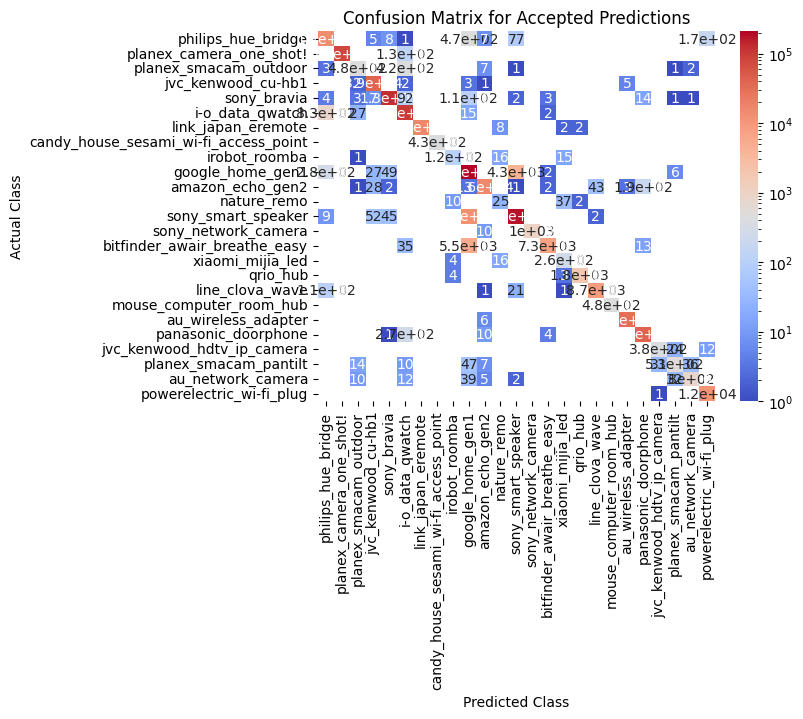

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

# Parameters
seed = 42
test_size = 0.2
confidence_threshold = 0.75

# Load data
column_names = [
    "name", "start_date", "start_time", "duration", "reverseDelta", "IoTMac", "hostMac",
    "IoTIP", "IoTIP_int", "hostIP", "hostIP_int", "ipProto", "IoTPort", "hostPort",
    "PacketCount", "BytesCount", "reversePacketCount", "reverseBytesCount", "SmallPktCount",
    "LargePktCount", "NonEmptyPktCount", "DataByteCount", "AvgIAT", "FirstNonEmptyPktSize",
    "MaxPktSize", "StdevPayloadSize", "StdevIAT", "AvgPacketSize", "reverseSmallPktCount",
    "reverseLargePktCount", "reverseNonEmptyPktCount", "reverseDataByteCount", "reverseAvgIAT",
    "PktSize", "reverseMaxPktSize", "reverseStdevPayloadSize", "reverseStdevIAT",
    "reverseAvgPacketSize", "reverseFlowExists", "remote", "broadcast", "HTTP", "HTTPS", "DNS",
    "NTP", "TCP_others", "UDP_others", "year_month"
]

headers=["philips_hue_bridge",
"planex_camera_one_shot!",
"planex_smacam_outdoor",
"jvc_kenwood_cu-hb1",
"sony_bravia",
"i-o_data_qwatch",
"link_japan_eremote",
"candy_house_sesami_wi-fi_access_point",
"irobot_roomba",
"google_home_gen1",
"amazon_echo_gen2",
"nature_remo",
"sony_smart_speaker",
"sony_network_camera",
"bitfinder_awair_breathe_easy",
"xiaomi_mijia_led",
"qrio_hub",
"line_clova_wave",
"mouse_computer_room_hub",
"au_wireless_adapter",
"panasonic_doorphone",
"jvc_kenwood_hdtv_ip_camera",
"planex_smacam_pantilt",
"au_network_camera"
,"powerelectric_wi-fi_plug"
]

train = pd.read_csv("/Users/kiran/VS code/data3001-model-cyber-6/data/aug80000.csv", names=column_names)
test = pd.read_csv("/Users/kiran/VS code/data3001-model-cyber-6/data/sep1M.csv", names=column_names)

encoder = LabelEncoder()
train['IoTMac'] = encoder.fit_transform(train['IoTMac'])
test['IoTMac'] = encoder.fit_transform(test['IoTMac'])
y_train = train['IoTMac']
y_test = test['IoTMac']
train = train.drop(['name', 'start_date', 'start_time', 'year_month', 'IoTIP', 'IoTIP_int', 'hostMac', 'IoTMac', 'hostIP', 'hostIP_int'], axis=1)
test = test.drop(['name', 'start_date', 'start_time', 'year_month', 'IoTIP', 'IoTIP_int', 'hostMac', 'IoTMac', 'hostIP', 'hostIP_int'], axis=1)

X_train = train
X_test = test


# Train model
model = RandomForestClassifier(max_depth=15, max_features=5, n_estimators=150, random_state=seed)
model.fit(X_train, y_train)

# Get predictions and confidence
final_predictions = model.predict(X_test)
tree_predictions = np.array([tree.predict(X_test) for tree in model.estimators_])
agreement_matrix = (tree_predictions == final_predictions)
agreement_percentages = np.sum(agreement_matrix, axis=0) / len(model.estimators_)

# Class-specific confidence thresholds
class_confidences = {label: [] for label in np.unique(y_train)}

# Get individual tree predictions for the training set
tree_predictions_train = np.array([tree.predict(X_train) for tree in model.estimators_])  # Shape: (150, 80000)

# Transpose tree_predictions_train for proper alignment
tree_predictions_train = tree_predictions_train.T 

# Loop to compute confidences for the training data
for label, pred, agreement in zip(
    y_train, 
    model.predict(X_train), 
    np.sum(tree_predictions_train == model.predict(X_train)[:, np.newaxis], axis=1)  # Sum agreements for each row
):
    if pred == label:
        class_confidences[label].append(agreement / len(model.estimators_))

# Calculate thresholds
class_thresholds = {
    label: {
        'mean': np.mean(confidences),
        'std_dev': np.std(confidences),
        'λ1': (np.mean(confidences), 1),
        'λ2': (np.mean(confidences) - np.std(confidences), np.mean(confidences) + np.std(confidences)),
        'λ3': (0.75, 1),
        'λ4': (np.mean(confidences) - 0.5*np.std(confidences), np.mean(confidences) + np.std(confidences)),
        'λ5': (np.mean(confidences) - np.std(confidences), 1),
        'λ6': (np.mean(confidences) - 0.5*np.std(confidences), 1),
        'λ7': (np.mean(confidences) - 0.75*np.std(confidences), 1)
    }
    for label, confidences in class_confidences.items()
}

# Apply thresholds
accepted_predictions = []
accepted_actuals = []
accepted_correct = 0
accepted_incorrect = 0
discarded_correct = 0
discarded_incorrect = 0
for idx, (pred, actual, agreement) in enumerate(zip(final_predictions, y_test, agreement_percentages)):
    threshold = class_thresholds[pred]['λ2']  # Change to λx as needed
    if threshold[0] <= agreement <= threshold[1]:
        accepted_predictions.append(pred)
        accepted_actuals.append(actual)
        if pred == actual:
            accepted_correct += 1
        else:
            accepted_incorrect += 1
    else:  # Discarded predictions
        if pred == actual:
            discarded_correct += 1
        else:
            discarded_incorrect += 1

# Evaluate performance
accepted_accuracy = accuracy_score(accepted_actuals, accepted_predictions)
accepted_f1_score = f1_score(accepted_actuals, accepted_predictions, average='macro')

overall_accuracy = accuracy_score(y_test, final_predictions)
overall_f1_score = f1_score(y_test, final_predictions, average='macro')

# Print results
print(f"========================================")
print(f"===========λ2 (Time Samples)============")
print(f"Overall Accuracy: {overall_accuracy:.5f}")
print(f"Overall Macro F1 Score: {overall_f1_score:.5f}")
print(f"Accepted Accuracy: {accepted_accuracy:.5f}")
print(f"Accepted Macro F1 Score: {accepted_f1_score:.5f}")
num_rejected_predictions = (len(y_test) - len(accepted_predictions))
num_accepted = len(accepted_predictions)
p_acc = num_accepted/len(y_test) * 100
p_rej = num_rejected_predictions/len(y_test) * 100
print(f"Accepted: {num_accepted} ({p_acc}%), Rejected: {num_rejected_predictions} ({p_rej}%)")
print(f"Accepted Correct: {accepted_correct}")
print(f"Accepted Incorrect: {accepted_incorrect}")
print(f"Discarded Correct: {discarded_correct}")
print(f"Discarded Incorrect: {discarded_incorrect}")

# Visualize
cmatrix = confusion_matrix(accepted_actuals, accepted_predictions)
present_classes = list(np.unique(np.concatenate((accepted_actuals, accepted_predictions))))
filtered_headers = [headers[i] for i in present_classes]


sns_map = sns.heatmap(cmatrix, annot=True, cmap='coolwarm', norm=LogNorm())
sns_map.set_xlabel('Predicted Class')
sns_map.set_ylabel('Actual Class')
sns_map.xaxis.set_ticklabels(filtered_headers, rotation=90)
sns_map.yaxis.set_ticklabels(filtered_headers, rotation=0)
plt.title('Confusion Matrix for Accepted Predictions')
plt.show()